# TYPHOON protocol showcase

Some of the system packages required for this notebook, including: `ip-route`, `tc`

Use the following cell to configure TYPHOON hyperparameters with environmental variables.

> NB! It should be run *prior* to all the other cells, since hyperparameters are being resolved only once upon `TyphoonCore` class import.

In [1]:
from os import environ

environ["TYPHOON_MIN_TIMEOUT"] = str(1)
environ["TYPHOON_MAX_TIMEOUT"] = str(4)
environ["TYPHOON_DEFAULT_TIMEOUT"] = str(3)
environ["TYPHOON_MIN_NEXT_IN"] = str(8.0)
environ["TYPHOON_MAX_NEXT_IN"] = str(32.0)
environ["TYPHOON_MAX_RETRIES"] = str(3)

This notebook requires some extra capabilities being applied to your `python` executable and also added to the `JuPyter` server process.
Don't worry: everything can be done just in a few steps.

> Why are these capabilities needed?
> Well, let's say for "safety" reasons.
> We do not want to apply **tc** (traffic control) commands directly to the loopback interface, right?
> That's why we need a pair of virtual interfaces with virtual IPs (`veth`s), so that we can apply fine-grained filters.
> And creating these interfaces requires some permissions.

First of all, the following cell should be executed before any other notebook cells (it might throw an error!):

In [2]:
from pathlib import Path
from sys import path

path.append(str(Path() / ".."))

from typhoon.utils import configure_ambient_permissions

configure_ambient_permissions()

Capabilities set successfully!


If the previous cell has thrown an error, that means that your `python` executable does not have `CAP_NET_ADMIN` and `CAP_NET_RAW` right now.
This can be solved by either of these three solutions:

1. Run the server in a `Docker` container (either `privileged` or with `CAP_NET_ADMIN` set) - the dockerfile is *not* provided.
2. Run the following cell to patch your current python executable (don't forget to run the next cell when you're done!).
3. Run the server with `sudo` (might be dangerous and not recommended!).

Whatever way you have chosen, the kernel should be restarted.

In [ ]:
from typhoon.utils import toggle_network_permissions

toggle_network_permissions(True)

Run this cell after you finished working with the notebook - it will unpatch you `python` executable.

In [ ]:
from typhoon.utils import toggle_network_permissions

toggle_network_permissions(False)

## Ideal connection

First and foremost, TYPHOON is designed to be **random**.
That includes:

1. Randomly-looking packet contents.
2. Random packet lengths.
3. Random delays between packets.

#### Packet contents

Packet content randomness is achieved by encryption.
Packets are encrypted completely, TYPHOON uses distinct keys for host-port pairs (provided by UDP header).
That is the baseline, some other hiding techniques might be added later (if needed).

#### Packet lengths

Packet length randomness is achieved by attaching a random tail to every package.
Packet length will be displayed in bar charts below as *bar heights*.

#### Packet delays

Packet delays randomness is achieved by applying a random timeout between service packets.
NB! This timeout is not applied to data packets, so in examples below you will usually see them as pairs.

Simple sanity check here.
Client connects to echo server, sends it a small package, receives response, checks it's the same and exits.

First two packets should be initialization packets, then we expect to observe a shadowride request packet (data + handshake) and a data response packet.
Last two packets should be termination packets.

As a result, a small sequence diagram is produced, showing packet exchange, their direction, size and timestamp.

Initialized client 'algae-0.0.3' with token: b'Random user token!'
Received data from client 45546: bytearray(b'Hi server!')


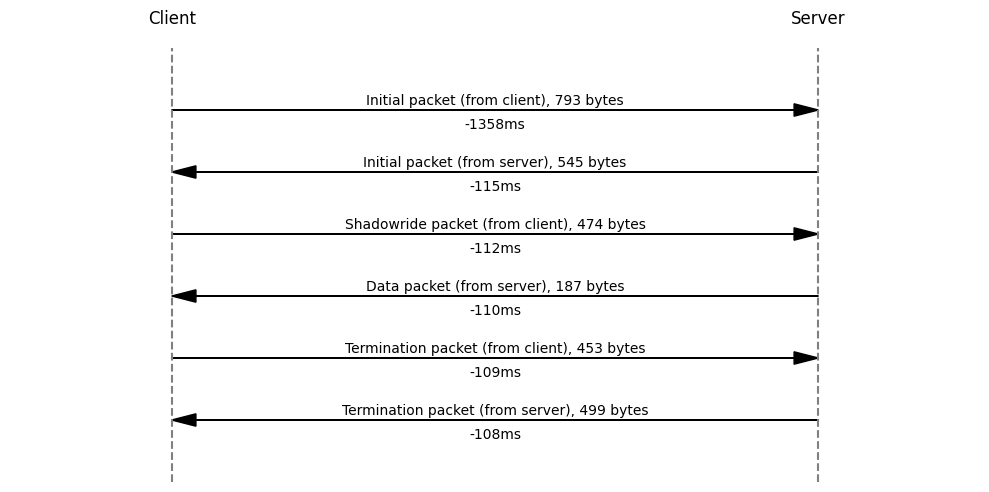

In [11]:
from sources.protocol.typhoon_socket import TyphoonListener, TyphoonClient
from sources.protocol.utils import ProtocolReturnCode

from typhoon.utils import GraphConf, sniff, LISTENER_KEY, CLIENT_KEY, USER_TOKEN


async def echo_server_callback(user_id: int, data: bytes) -> bytes:
    print(f"Received data from client {user_id}: {data}")
    return data


async def success_listener_callback(name: str, token: bytes) -> ProtocolReturnCode:
    print(f"Initialized client '{name}' with token: {token}")
    return ProtocolReturnCode.SUCCESS


async with sniff(GraphConf()) as s:
    async with TyphoonListener(LISTENER_KEY, s.server_address).ctx(success_listener_callback, echo_server_callback) as l:
        async with TyphoonClient(CLIENT_KEY, USER_TOKEN, s.server_address, l.port, s.client_address).ctx() as c:
            request = b"Hi server!"
            await c.write(request)
            response = await c.read()
            assert(request == response)

Stale connection is shown here.
Client is connected to server, waits for some time and disappears.
Server tries to restore connection, but fails and closes it after some time.

First two packets should be initialization packets, then several successful handshakes should happen.
Finally, some unsuccessful handshake attempts by server should be present - and finally a termination packet.

As a result, a small packet plot is produced, showing packet exchange, their type, size and timestamp.

Connection established! Sleeping for 180.0...
Connection interrupted! Waiting for 128.0...
TyphoonServer: 17:13:16.035 ERROR - Invalid packet read error: [Errno 111] Connection refused
TyphoonServer: 17:13:46.511 ERROR - Invalid packet read error: [Errno 111] Connection refused
TyphoonServer: 17:14:30.282 ERROR - Invalid packet read error: [Errno 111] Connection refused


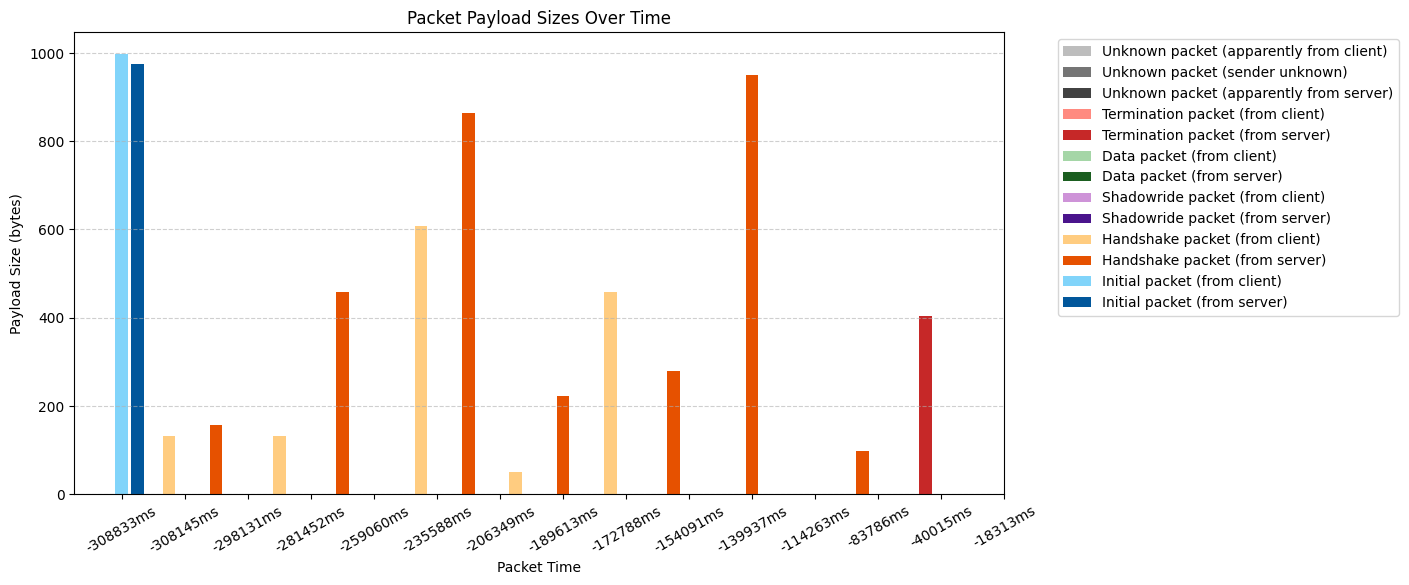

In [10]:
from asyncio import sleep
from os import environ

from sources.protocol.typhoon_socket import TyphoonListener, TyphoonClient

from typhoon.utils import PlotConf, sniff, LISTENER_KEY, CLIENT_KEY, USER_TOKEN

SLEEP_DELAY = (float(environ["TYPHOON_MAX_NEXT_IN"]) + float(environ["TYPHOON_MAX_TIMEOUT"])) * 5
TIMEOUT_DELAY = float(environ["TYPHOON_MAX_NEXT_IN"]) * (float(environ["TYPHOON_MAX_RETRIES"]) + 1)


async with sniff(PlotConf()) as s:
    async with TyphoonListener(LISTENER_KEY, s.server_address).ctx(data_callback=lambda _: None) as l:
        async with TyphoonClient(CLIENT_KEY, USER_TOKEN, s.server_address, l.port, s.client_address).ctx(lambda _: None, False) as c:
            print(f"Connection established! Sleeping for {SLEEP_DELAY}...")
            await sleep(SLEEP_DELAY)
        print(f"Connection interrupted! Waiting for {TIMEOUT_DELAY}...")
        await sleep(TIMEOUT_DELAY)

Successful connection is shown here.
Client is connected to server, they exchange data packets every second.
In the end, the connection is terminated successfully.

First two packets should be initialization packets, last two packets should be termination packets.
In between, multiple data and shadowride packages should be observable.
Because of the frequent data exchange, no pure handshake packets should be there.

As a result, a small packet plot is produced, showing packet exchange, their type and size.
The receiving time is omitted.

TyphoonListener: 17:08:23.198 INFO - Binding to 192.168.111.1...
TyphoonListener: 17:08:23.199 INFO - Listening at 192.168.111.1:51557...
TyphoonClient: 17:08:23.199 INFO - Binding client to 192.168.111.2...
TyphoonClient: 17:08:23.200 INFO - Connecting to listener at 192.168.111.1:51557
TyphoonClient: 17:08:23.200 INFO - Current user address: 192.168.111.2:52684
TyphoonClient: 17:08:23.201 DEBUG - Trying initialization attempt 0 (with packet of length 1112)...
TyphoonClient: 17:08:23.202 DEBUG - Waiting for server response for 14356 milliseconds...
TyphoonListener: 17:08:23.203 DEBUG - Initializing user at 192.168.111.2:52684 (with packet of length 1112)...
TyphoonListener: 17:08:23.204 INFO - User initialization request from 'algae-0.0.3' with token: b'Random user token!'
TyphoonServer: 17:08:23.204 INFO - Binding server to 192.168.111.1...
TyphoonServer: 17:08:23.204 INFO - Serving for 192.168.111.2:52684 with assigned user ID 57387
TyphoonServer: 17:08:23.205 INFO - Installing read

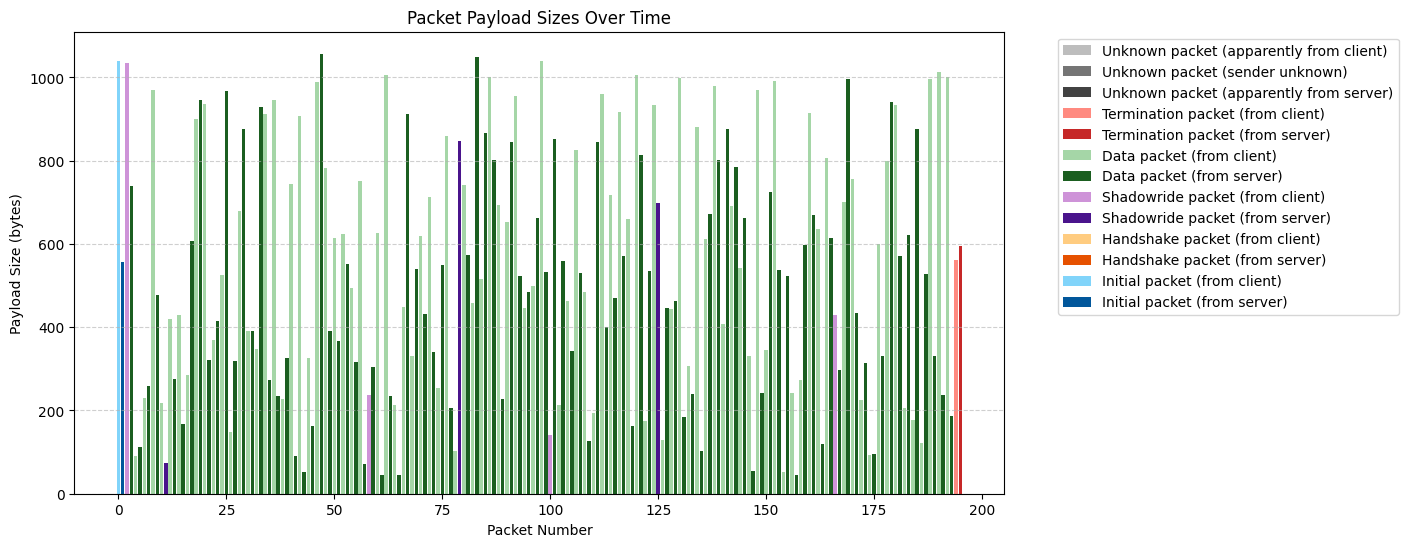

In [9]:
from sources.protocol.typhoon_socket import TyphoonListener, TyphoonClient

from typhoon.utils import PlotConf, sniff, SequenceConfig, LISTENER_KEY, CLIENT_KEY, USER_TOKEN

CONFIG = SequenceConfig(messages=96, quiet=True, client_sequence=lambda _: 1, server_sequence=lambda _: 0)


async with sniff(PlotConf(expand_time=False)) as s:
    async with TyphoonListener(LISTENER_KEY, s.server_address).ctx(data_callback=CONFIG.seq_server_callback, log_level=10) as l:
        async with TyphoonClient(CLIENT_KEY, USER_TOKEN, s.server_address, l.port, s.client_address).ctx(CONFIG.seq_client_callback, log_level=10) as c:
            await CONFIG.process(c)

## Network in chaos

normal

TyphoonListener: 17:01:22.236 INFO - Binding to 192.168.111.1...
TyphoonListener: 17:01:22.237 INFO - Listening at 192.168.111.1:59283...
TyphoonClient: 17:01:22.238 INFO - Binding client to 192.168.111.2...
TyphoonClient: 17:01:22.238 INFO - Connecting to listener at 192.168.111.1:59283
TyphoonClient: 17:01:22.239 INFO - Current user address: 192.168.111.2:39729
TyphoonClient: 17:01:22.240 DEBUG - Trying initialization attempt 0 (with packet of length 828)...
TyphoonClient: 17:01:22.241 DEBUG - Waiting for server response for 14500 milliseconds...
TyphoonListener: 17:01:22.242 DEBUG - Initializing user at 192.168.111.2:39729 (with packet of length 828)...
TyphoonListener: 17:01:22.243 INFO - User initialization request from 'algae-0.0.3' with token: b'Random user token!'
TyphoonServer: 17:01:22.243 INFO - Binding server to 192.168.111.1...
TyphoonServer: 17:01:22.244 INFO - Serving for 192.168.111.2:39729 with assigned user ID 33672
TyphoonServer: 17:01:22.244 INFO - Installing readin

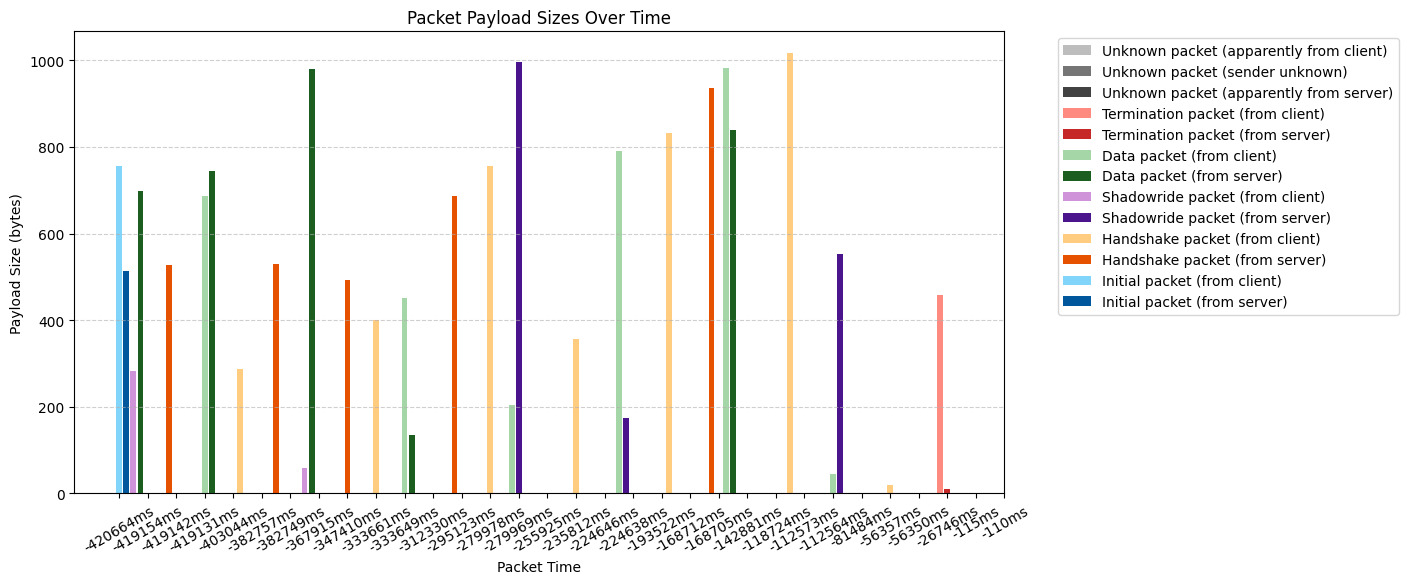

In [8]:
from sources.protocol.typhoon_socket import TyphoonListener, TyphoonClient

from typhoon.utils import PlotConf, sniff, SequenceConfig, LISTENER_KEY, CLIENT_KEY, USER_TOKEN

CONFIG = SequenceConfig()


async with sniff(PlotConf()) as s:
    async with TyphoonListener(LISTENER_KEY, s.server_address).ctx(data_callback=CONFIG.seq_server_callback, log_level=10) as l:
        async with TyphoonClient(CLIENT_KEY, USER_TOKEN, s.server_address, l.port, s.client_address).ctx(CONFIG.seq_client_callback, log_level=10) as c:
            await CONFIG.process(c)

jitter

TyphoonListener: 16:51:57.767 INFO - Binding to 192.168.111.1...
TyphoonListener: 16:51:57.768 INFO - Listening at 192.168.111.1:41711...
TyphoonClient: 16:51:57.770 INFO - Binding client to 192.168.111.2...
TyphoonClient: 16:51:57.771 INFO - Connecting to listener at 192.168.111.1:41711
TyphoonClient: 16:51:57.773 INFO - Current user address: 192.168.111.2:55801
TyphoonClient: 16:51:57.774 DEBUG - Trying initialization attempt 0 (with packet of length 622)...
TyphoonClient: 16:51:57.776 DEBUG - Waiting for server response for 13799 milliseconds...
TyphoonListener: 16:51:57.942 DEBUG - Initializing user at 192.168.111.2:55801 (with packet of length 622)...
TyphoonListener: 16:51:57.945 INFO - User initialization request from 'algae-0.0.3' with token: b'Random user token!'
TyphoonServer: 16:51:57.946 INFO - Binding server to 192.168.111.1...
TyphoonServer: 16:51:57.947 INFO - Serving for 192.168.111.2:55801 with assigned user ID 49558
TyphoonServer: 16:51:57.948 INFO - Installing readin

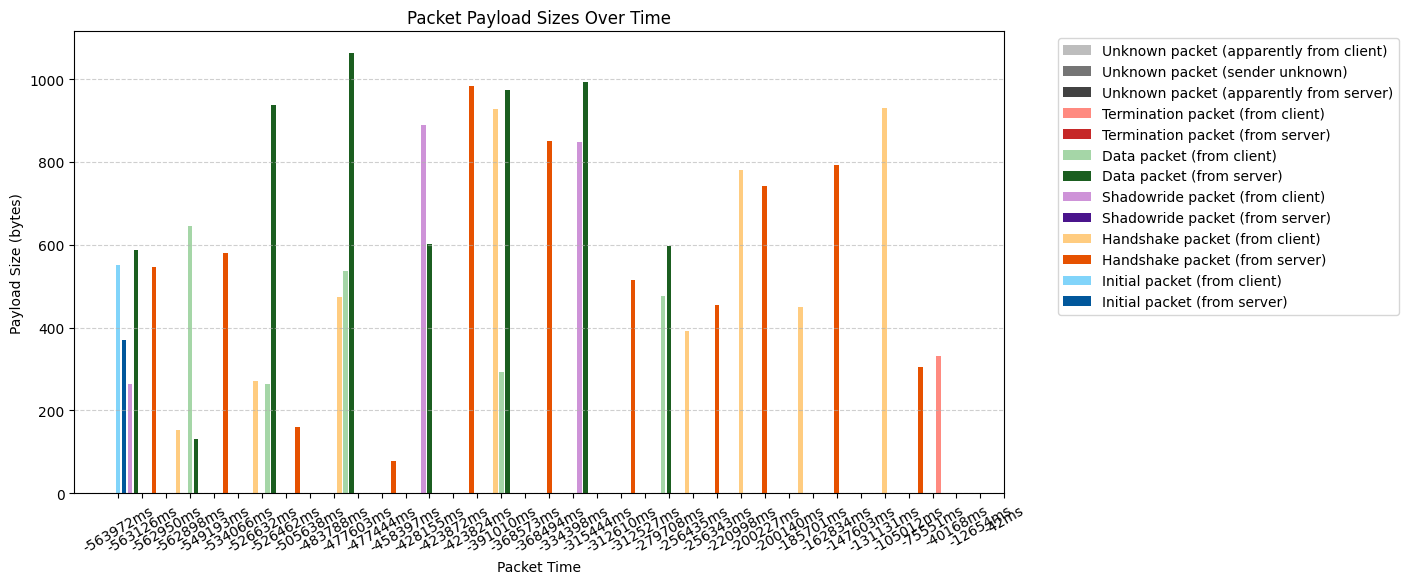

In [7]:
from asyncio import sleep

from sources.protocol.typhoon_socket import TyphoonListener, TyphoonClient

from typhoon.utils import PlotConf, sniff, SequenceConfig, LISTENER_KEY, CLIENT_KEY, USER_TOKEN

CONFIG = SequenceConfig()


async with sniff(PlotConf(), r"delay 100ms 75ms") as s:
    async with TyphoonListener(LISTENER_KEY, s.server_address).ctx(data_callback=CONFIG.seq_server_callback, log_level=10) as l:
        async with TyphoonClient(CLIENT_KEY, USER_TOKEN, s.server_address, l.port, s.client_address).ctx(CONFIG.seq_client_callback, log_level=10) as c:
            await CONFIG.process(c)
            await sleep(CONFIG.base_delay() * 4)

drop

> WARNING! The following cell might fail in approximately 3% of the runs!

TyphoonListener: 16:44:56.780 INFO - Binding to 192.168.111.1...
TyphoonListener: 16:44:56.781 INFO - Listening at 192.168.111.1:39558...
TyphoonClient: 16:44:56.782 INFO - Binding client to 192.168.111.2...
TyphoonClient: 16:44:56.782 INFO - Connecting to listener at 192.168.111.1:39558
TyphoonClient: 16:44:56.782 INFO - Current user address: 192.168.111.2:35932
TyphoonClient: 16:44:56.783 DEBUG - Trying initialization attempt 0 (with packet of length 925)...
TyphoonClient: 16:44:56.784 DEBUG - Waiting for server response for 14344 milliseconds...
TyphoonListener: 16:44:56.785 DEBUG - Initializing user at 192.168.111.2:35932 (with packet of length 925)...
TyphoonListener: 16:44:56.786 INFO - User initialization request from 'algae-0.0.3' with token: b'Random user token!'
TyphoonServer: 16:44:56.786 INFO - Binding server to 192.168.111.1...
TyphoonServer: 16:44:56.787 INFO - Serving for 192.168.111.2:35932 with assigned user ID 38106
TyphoonServer: 16:44:56.787 INFO - Installing readin

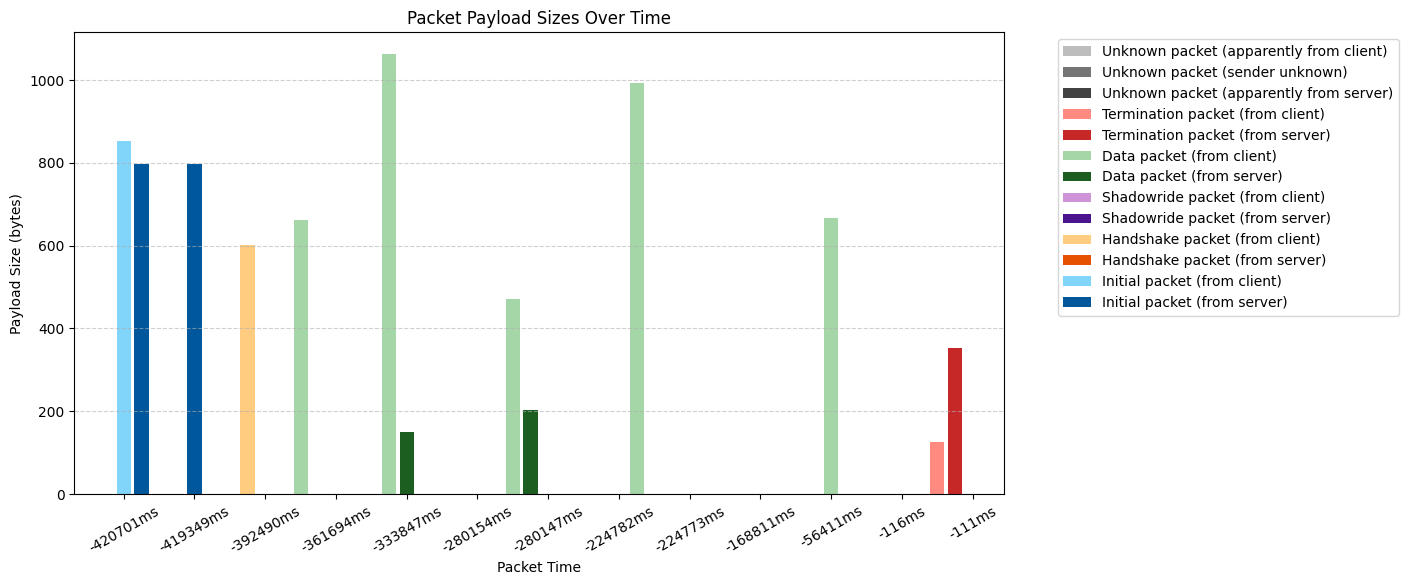

In [6]:
from sources.protocol.typhoon_socket import TyphoonListener, TyphoonClient

from typhoon.utils import PlotConf, sniff, SequenceConfig, LISTENER_KEY, CLIENT_KEY, USER_TOKEN

CONFIG = SequenceConfig()


async with sniff(PlotConf(), r"loss 30%") as s:
    async with TyphoonListener(LISTENER_KEY, s.server_address).ctx(data_callback=CONFIG.seq_server_callback, log_level=10) as l:
        async with TyphoonClient(CLIENT_KEY, USER_TOKEN, s.server_address, l.port, s.client_address).ctx(CONFIG.seq_client_callback, log_level=10) as c:
            await CONFIG.process(c)

duplicate

TyphoonListener: 16:37:56.652 INFO - Binding to 192.168.111.1...
TyphoonListener: 16:37:56.654 INFO - Listening at 192.168.111.1:53402...
TyphoonClient: 16:37:56.656 INFO - Binding client to 192.168.111.2...
TyphoonClient: 16:37:56.657 INFO - Connecting to listener at 192.168.111.1:53402
TyphoonClient: 16:37:56.658 INFO - Current user address: 192.168.111.2:48595
TyphoonClient: 16:37:56.660 DEBUG - Trying initialization attempt 0 (with packet of length 1147)...
TyphoonClient: 16:37:56.662 DEBUG - Waiting for server response for 13550 milliseconds...
TyphoonListener: 16:37:56.665 DEBUG - Initializing user at 192.168.111.2:48595 (with packet of length 1147)...
TyphoonListener: 16:37:56.666 INFO - User initialization request from 'algae-0.0.3' with token: b'Random user token!'
TyphoonServer: 16:37:56.668 INFO - Binding server to 192.168.111.1...
TyphoonServer: 16:37:56.669 INFO - Serving for 192.168.111.2:48595 with assigned user ID 51496
TyphoonServer: 16:37:56.670 INFO - Installing read

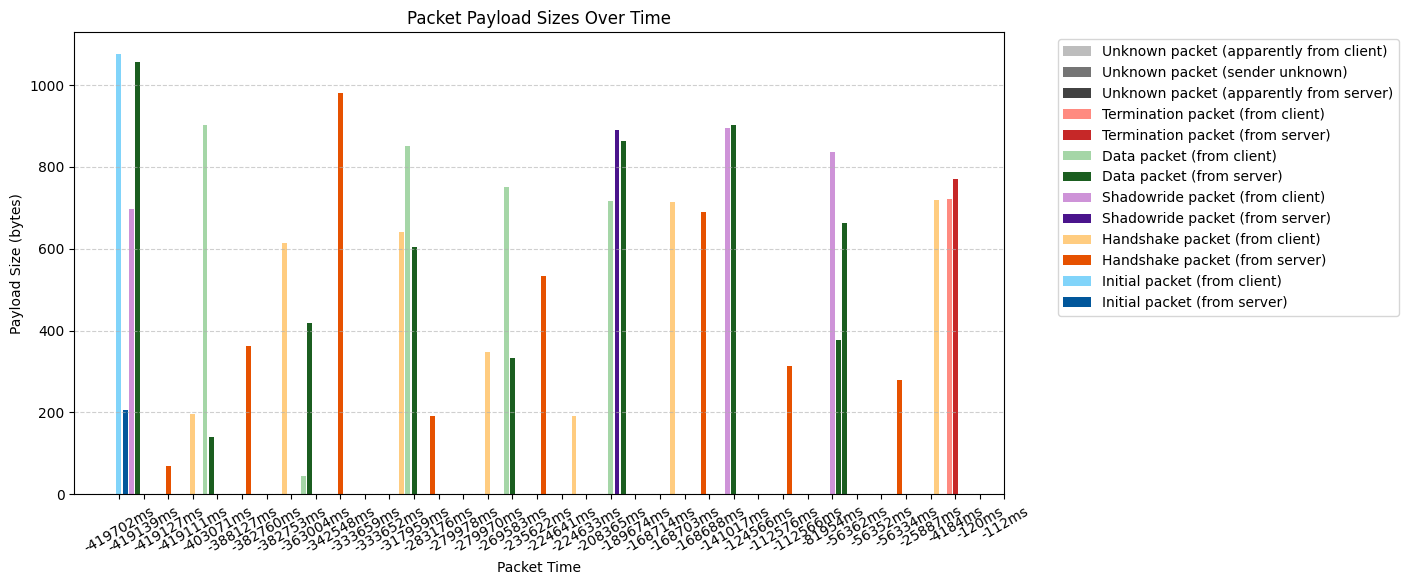

In [5]:
from sources.protocol.typhoon_socket import TyphoonListener, TyphoonClient

from typhoon.utils import PlotConf, sniff, SequenceConfig, LISTENER_KEY, CLIENT_KEY, USER_TOKEN

CONFIG = SequenceConfig()


async with sniff(PlotConf(), r"duplicate 30%") as s:
    async with TyphoonListener(LISTENER_KEY, s.server_address).ctx(data_callback=CONFIG.seq_server_callback, log_level=10) as l:
        async with TyphoonClient(CLIENT_KEY, USER_TOKEN, s.server_address, l.port, s.client_address).ctx(CONFIG.seq_client_callback, log_level=10) as c:
            await CONFIG.process(c)

reorder

TyphoonListener: 16:29:25.822 INFO - Binding to 192.168.111.1...
TyphoonListener: 16:29:25.823 INFO - Listening at 192.168.111.1:41276...
TyphoonClient: 16:29:25.824 INFO - Binding client to 192.168.111.2...
TyphoonClient: 16:29:25.825 INFO - Connecting to listener at 192.168.111.1:41276
TyphoonClient: 16:29:25.826 INFO - Current user address: 192.168.111.2:55877
TyphoonClient: 16:29:25.827 DEBUG - Trying initialization attempt 0 (with packet of length 199)...
TyphoonClient: 16:29:25.829 DEBUG - Waiting for server response for 14183 milliseconds...
TyphoonListener: 16:29:25.957 DEBUG - Initializing user at 192.168.111.2:55877 (with packet of length 199)...
TyphoonListener: 16:29:25.958 INFO - User initialization request from 'algae-0.0.3' with token: b'Random user token!'
TyphoonServer: 16:29:25.960 INFO - Binding server to 192.168.111.1...
TyphoonServer: 16:29:25.960 INFO - Serving for 192.168.111.2:55877 with assigned user ID 49653
TyphoonServer: 16:29:25.961 INFO - Installing readin

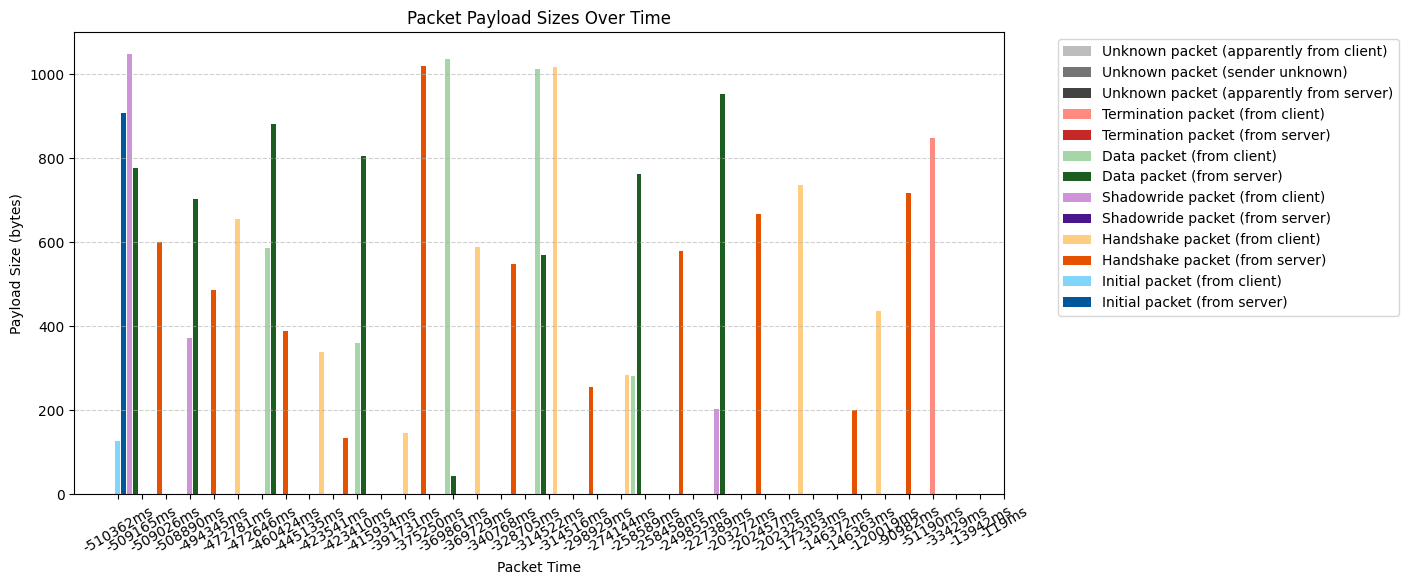

In [4]:
from asyncio import sleep

from sources.protocol.typhoon_socket import TyphoonListener, TyphoonClient

from typhoon.utils import PlotConf, sniff, SequenceConfig, LISTENER_KEY, CLIENT_KEY, USER_TOKEN

CONFIG = SequenceConfig()


async with sniff(PlotConf(), r"delay 125ms reorder 30% 50%") as s:
    async with TyphoonListener(LISTENER_KEY, s.server_address).ctx(data_callback=CONFIG.seq_server_callback, log_level=10) as l:
        async with TyphoonClient(CLIENT_KEY, USER_TOKEN, s.server_address, l.port, s.client_address).ctx(CONFIG.seq_client_callback, log_level=10) as c:
            await CONFIG.process(c)
            await sleep(CONFIG.base_delay() * 2.5)

corrupt

TyphoonListener: 16:22:25.309 INFO - Binding to 192.168.111.1...
TyphoonListener: 16:22:25.311 INFO - Listening at 192.168.111.1:41758...
TyphoonClient: 16:22:25.312 INFO - Binding client to 192.168.111.2...
TyphoonClient: 16:22:25.312 INFO - Connecting to listener at 192.168.111.1:41758
TyphoonClient: 16:22:25.313 INFO - Current user address: 192.168.111.2:40855
TyphoonClient: 16:22:25.314 DEBUG - Trying initialization attempt 0 (with packet of length 787)...
TyphoonClient: 16:22:25.316 DEBUG - Waiting for server response for 13991 milliseconds...
TyphoonListener: 16:22:25.321 DEBUG - Initializing user at 192.168.111.2:40855 (with packet of length 787)...
TyphoonListener: 16:22:25.323 INFO - User initialization request from 'algae-0.0.3' with token: b'Random user token!'
TyphoonServer: 16:22:25.324 INFO - Binding server to 192.168.111.1...
TyphoonServer: 16:22:25.327 INFO - Serving for 192.168.111.2:40855 with assigned user ID 58267
TyphoonServer: 16:22:25.328 INFO - Installing readin

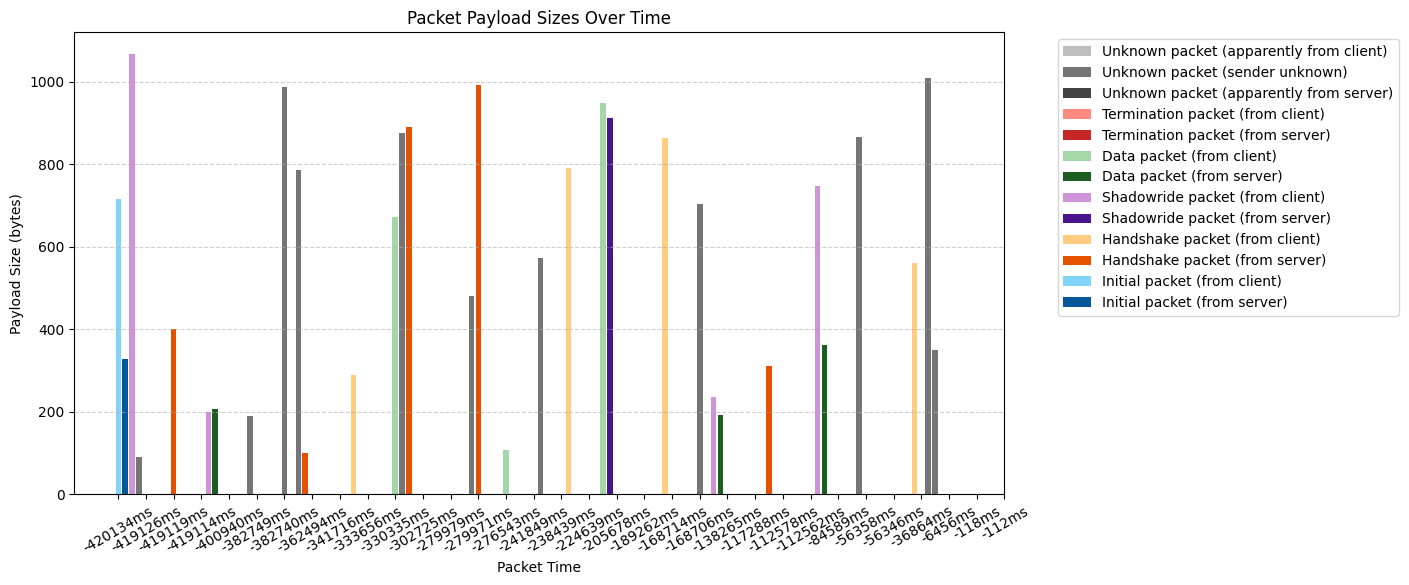

In [3]:
from sources.protocol.typhoon_socket import TyphoonListener, TyphoonClient

from typhoon.utils import PlotConf, sniff, SequenceConfig, LISTENER_KEY, CLIENT_KEY, USER_TOKEN

CONFIG = SequenceConfig(quiet=True)


async with sniff(PlotConf(), r"corrupt 30%") as s:
    async with TyphoonListener(LISTENER_KEY, s.server_address).ctx(data_callback=CONFIG.seq_server_callback, log_level=10) as l:
        async with TyphoonClient(CLIENT_KEY, USER_TOKEN, s.server_address, l.port, s.client_address).ctx(CONFIG.seq_client_callback, log_level=10) as c:
            await CONFIG.process(c)